### Milestone 1 
The client’s media group spent **$10,000** on the campaign, primarily in online display advertising.

- Estimate effect of the display advertising 
- Estimated ROI of the display adverstising 

The variables: 
* CUSTID – customer ID
* CART_TOTAL – dollar amount the customer checked out for
* PREVIOUS_CHECKOUTS – number of checkouts observed previously for cus- tomer
* PAGE_VIEWS – number of pages customer viewed before latest checkout
* ESTIMATED_INCOME_DECILE – modeled income decile using first party data
* PRODUCT_VIEWS–numberofproductsviewedbycustomer(multipleproducts per page)
* ATTRIB_DISPLAY_AD – flag for whether customer was attributed to have seen display ad

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
import statsmodels.api as sm

In [3]:
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [4]:
m1_dir = '/Users/tsebaotshewarega/Documents/Third year/Fall 2023/QTM 385/eCommerce/eCommerce_class/ecomm_performance_data/milestone-1/ecomm_rev_2020.csv'
m2_dir = '/Users/tsebaotshewarega/Documents/Third year/Fall 2023/QTM 385/eCommerce/eCommerce_class/ecomm_performance_data/milestone-2/ecomm_rev_2020_incl_assn.csv'
m3_dir = '/Users/tsebaotshewarega/Documents/Third year/Fall 2023/QTM 385/eCommerce/eCommerce_class/ecomm_performance_data/milestone-3/ecomm_rev_2020_omnipotent.csv'

m1_df = pd.read_csv(m1_dir)
m2_df = pd.read_csv(m2_dir)
m3_df = pd.read_csv(m3_dir)


# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
one_hot_encoded = encoder.fit_transform(m1_df[['ESTIMATED_INCOME_DECILE']])

# Convert the result to a DataFrame for better visualization
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['ESTIMATED_INCOME_DECILE']))

# Concatenate the one-hot-encoded DataFrame with the original DataFrame
m1_df = pd.concat([m1_df, one_hot_df], axis=1)
m2_df = pd.concat([m2_df, one_hot_df], axis=1)
m3_df = pd.concat([m3_df, one_hot_df], axis=1)

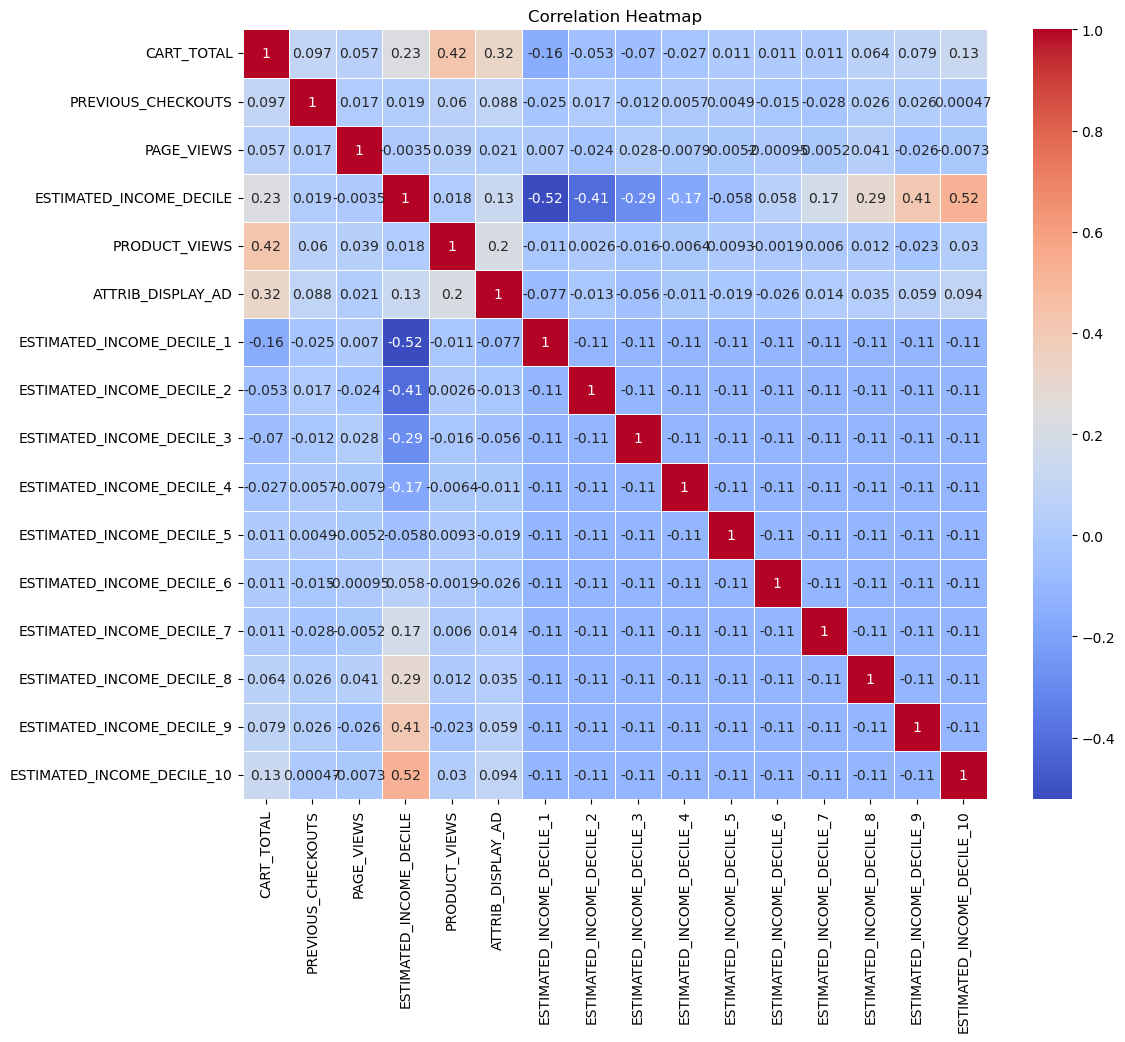

In [5]:
# EDA 
correlation_matrix = m1_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [6]:
TREATMENT = 'ATTRIB_DISPLAY_AD'
OUTCOME = 'CART_TOTAL'
round(m1_df.groupby(TREATMENT)[OUTCOME].describe(),3)

,count,mean,std,min,25%,50%,75%,max
ATTRIB_DISPLAY_AD,,,,,,,,
0,2136.0,43.884,20.833,0.00,30.622,42.31,55.968,115.38
1,739.0,58.878,14.309,38.31,47.410,55.45,67.850,114.75


In [7]:
round(m1_df.groupby(TREATMENT).mean(),3)

,CART_TOTAL,PREVIOUS_CHECKOUTS,PAGE_VIEWS,ESTIMATED_INCOME_DECILE,PRODUCT_VIEWS,ESTIMATED_INCOME_DECILE_1,ESTIMATED_INCOME_DECILE_2,ESTIMATED_INCOME_DECILE_3,ESTIMATED_INCOME_DECILE_4,ESTIMATED_INCOME_DECILE_5,ESTIMATED_INCOME_DECILE_6,ESTIMATED_INCOME_DECILE_7,ESTIMATED_INCOME_DECILE_8,ESTIMATED_INCOME_DECILE_9,ESTIMATED_INCOME_DECILE_10
ATTRIB_DISPLAY_AD,,,,,,,,,,,,,,,
0,43.884,0.817,4.982,5.270,9.861,0.114,0.103,0.110,0.102,0.103,0.104,0.097,0.094,0.089,0.083
1,58.878,1.088,5.089,6.149,10.344,0.061,0.093,0.072,0.095,0.091,0.087,0.107,0.118,0.130,0.147


There is covariate imbalance between the treated and control group 
Difference in means of the two groups would be a biased estimate of the treatment effect. 

In [8]:
ATE_naive = m1_df.loc[m1_df["ATTRIB_DISPLAY_AD"]==1]["CART_TOTAL"].mean() - m1_df.loc[m1_df["ATTRIB_DISPLAY_AD"]==0]["CART_TOTAL"].mean()
print (f"The naive estimated effect of the dispaly ads is: {ATE_naive}")


The naive estimated effect of the dispaly ads is: 14.994204518962235


### Propensity Score Matching 
- predicting the probability of receiving the treatment given the confounders using logistic regression

In [9]:
# Preparing med datafram:
# 1
T = 'ATTRIB_DISPLAY_AD'
Y = 'CART_TOTAL'

#2
X = ['PREVIOUS_CHECKOUTS', 'PAGE_VIEWS', 'ESTIMATED_INCOME_DECILE', 'PRODUCT_VIEWS']

# Creating a dataframe with frac percent of the data
# values of original dataframe
prop_score = m1_df.sample(frac = 0.3)
 
# Creating dataframe with
# rest of the 70% values
ps_match = m1_df.drop(prop_score.index)

### WHY ARE WE SPLITTING DATA?
# To account for the fact that we are using estimated propensity
# rather than the true propensity score. 

In [10]:
# Computing the propensity score using prop_score dataframe

from sklearn.linear_model import LogisticRegression as LR
#3
ps_model = LR().fit(prop_score[X], prop_score[T])

#4
data_ps_1 = ps_match.assign(e_hat=ps_model.predict_proba(ps_match[X])[:, 1])



In [11]:
data_ps_1['ones'] = 1
data_ps_1.head()

,CUSTID,CART_TOTAL,PREVIOUS_CHECKOUTS,PAGE_VIEWS,ESTIMATED_INCOME_DECILE,PRODUCT_VIEWS,ATTRIB_DISPLAY_AD,ESTIMATED_INCOME_DECILE_1,ESTIMATED_INCOME_DECILE_2,ESTIMATED_INCOME_DECILE_3,ESTIMATED_INCOME_DECILE_4,ESTIMATED_INCOME_DECILE_5,ESTIMATED_INCOME_DECILE_6,ESTIMATED_INCOME_DECILE_7,ESTIMATED_INCOME_DECILE_8,ESTIMATED_INCOME_DECILE_9,ESTIMATED_INCOME_DECILE_10,e_hat,ones
0,3218c960b1144725db928e476eddf136,17.00,0,5,1,9,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121162,1
3,1941f3295dae57c0b5deeedfb0cedb0c,35.95,5,9,9,10,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.368583,1
4,dd50c9de777380b997e1769d61c9829e,42.23,0,4,7,10,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.282001,1
7,ca5fc7a16ddc972f2b390e9e892c8421,38.58,0,4,4,10,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.229065,1
8,a83e89e4e954711be9cea2eda7a94b73,46.23,6,9,1,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.231763,1


In [12]:
from sklearn.neighbors import KNeighborsRegressor

treated = data_ps_1.query("ATTRIB_DISPLAY_AD==1")
untreated = data_ps_1.query("ATTRIB_DISPLAY_AD==0")

x = ['ones', 'e_hat']
y = 'CART_TOTAL'

# e_hat: The estimated propensity score for each observation in ps_match.
# ones: A constant feature used as a baseline input for KNN

mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[x], untreated[y])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[x], treated[y])

data_ps_1 = pd.concat([
    # find matches for the treated looking at the untreated knn model
    treated.assign(match=mt0.predict(treated[x])),
    
    # find matches for the untreated looking at the treated knn model
    untreated.assign(match=mt1.predict(untreated[x]))
])

data_ps_1.head()

,CUSTID,CART_TOTAL,PREVIOUS_CHECKOUTS,PAGE_VIEWS,ESTIMATED_INCOME_DECILE,PRODUCT_VIEWS,ATTRIB_DISPLAY_AD,ESTIMATED_INCOME_DECILE_1,ESTIMATED_INCOME_DECILE_2,ESTIMATED_INCOME_DECILE_3,ESTIMATED_INCOME_DECILE_4,ESTIMATED_INCOME_DECILE_5,ESTIMATED_INCOME_DECILE_6,ESTIMATED_INCOME_DECILE_7,ESTIMATED_INCOME_DECILE_8,ESTIMATED_INCOME_DECILE_9,ESTIMATED_INCOME_DECILE_10,e_hat,ones,match
8,a83e89e4e954711be9cea2eda7a94b73,46.23,6,9,1,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.231763,1,33.15
10,b9984ba3c04181ef24e6134ff4a13035,48.14,2,1,10,10,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.410584,1,48.20
12,387bc774b7eaf5bf4e8541f3e705e1ab,68.22,2,7,7,11,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.390413,1,72.13
14,01a40e60f561d39da926e1260536e49b,71.59,0,2,10,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.468864,1,34.19
17,478274ccaf1130585c27dd2b4a69dbcb,63.66,0,10,5,11,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.283824,1,78.65


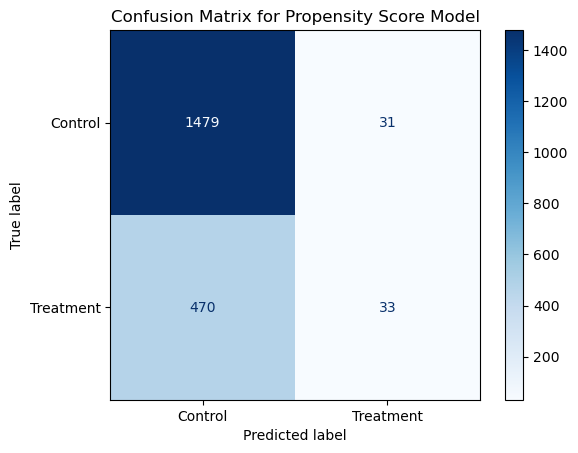

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities using the propensity score model
ps_model_proba = ps_model.predict_proba(ps_match[X])[:, 1]

# Convert probabilities to binary predictions (use 0.5 threshold)
ps_model_pred = (ps_model_proba >= 0.5).astype(int)

# True labels (actual treatment assignment)
true_labels = ps_match[T]

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, ps_model_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Control', 'Treatment'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Propensity Score Model')
plt.show()

In [14]:
ATE_prop = np.mean((2*data_ps_1["ATTRIB_DISPLAY_AD"] - 1)*(data_ps_1["CART_TOTAL"] - data_ps_1["match"]))
print(f"The estimated effect of the diplay ad after propensity score matching using logistic regression is: {round(ATE_prop, 3)}$")
ROI = ((739.0 * 12.204) - 10000) /10000 * 100
print(f"ROI is {round(ROI, 2)}%")

The estimated effect of the diplay ad after propensity score matching using logistic regression is: 12.461$
ROI is -9.81%


This means on average, customers that looked at the ads spent $12 more than customers that didn't. The ROI is -9.81% showing that Nordstorm incurred loss on the investment. It's good to note, the naive estimate of the efect gives a positive ROI of 4%. 